In [1]:
DATE = "2021-10-09"
TASK = "hmp-ibd"
DIR = mkpath("$(homedir())/$(DATE)-$(TASK)")
cd(DIR)

In [2]:
import Pkg
pkgs = [
    "BioAlignments",
    "BioSequences",
    "Clustering",
    "CodecZlib",
    "CodecBzip2",
#     "Colors",
#     "Combinatorics",
    "DataFrames",
    "DataStructures",
    "Dates",
#     "DelimitedFiles",
    "Distances",
    "Distributions",
#     "EzXML",
    "FASTX",
#     "GFF3",
    "GLM",
    "GraphPlot",
#     "HTTP",
#     "Impute",
#     "JSON",
    "LightGraphs",
    "LsqFit",
#     "LSHFunctions",
#     "Measures",
    "MetaGraphs",
    "https://github.com/cjprybol/Mycelia.git",
    "MultivariateStats",
#     "NumericIO",
    "OnlineStats",
#     "PlotlyJS",
#     "Plots",
    "Primes",
#     "Printf",
    "ProgressMeter",
    "Random",
    "Revise",
    "SparseArrays",
    "Statistics",
    "StatsBase",
    "StatsPlots",
#     "StringDistances",
    "uCSV",
#     "XLSX",
    "RollingFunctions",
]

unregistered_packages = filter(pkg -> occursin(r"(^https|git$)", pkg), pkgs)
registered_packages = setdiff(pkgs, unregistered_packages)

for pkg in registered_packages
    try
        eval(Meta.parse("import $(pkg)"))
    catch
        Pkg.add(pkg)
        Pkg.build(pkg)
        eval(Meta.parse("import $(pkg)"))
    end
end

for pkg_url in unregistered_packages
    pkg_name = replace(basename(pkg_url), ".git" => "")
    try
        eval(Meta.parse("import $(pkg_name)"))
    catch
        Pkg.develop(url=pkg_url)
        Pkg.build(pkg_name)
        eval(Meta.parse("import $(pkg_name)"))
    end
end

In [3]:
function find_rank_match(sorted_rank, terminal_node)
    
    name_map = Dict(
        "thermi" => "Deinococcus-Thermus"
    )
    
    normalized_name = replace(replace(terminal_node, r"\w__" => ""), '_' => ' ')
    sorted_search_index_range = searchsorted(sorted_rank, normalized_name)
    if !isempty(sorted_search_index_range)
        @assert length(sorted_search_index_range) == 1
        hit = first(sorted_search_index_range)
    else
        is_full_hit = falses(length(sorted_rank))
        partial_hits = zeros(Int, length(sorted_rank))
        normalized_name = lowercase(normalized_name)
        for (i, scientific_name) in enumerate(sorted_rank)
            lsn = lowercase(scientific_name)
            if occursin(normalized_name, lsn)
                is_full_hit[i] = true
            else
                nlsn = replace(lowercase(scientific_name), r"[^\w\s]+" => "")
#                 @show lsn, nlsn, normalized_name
                partial_hits[i] = length(intersect(Set(split(nlsn, " ")), Set(split(normalized_name, " "))))
            end
        end
        full_hits = findall(is_full_hit)
        if length(full_hits) == 1
            hit = first(full_hits)
        elseif length(full_hits) > 1
            if !haskey(name_map, normalized_name)
#                 @show normalized_name, rank, sorted_rank[full_hits]
#                 error()
                return nothing
            else
                hit = searchsortedfirst(sorted_rank, name_map[normalized_name])
            end
        else
            max_hit_count = maximum(partial_hits)
            full_hits = findall(hit_count -> hit_count == max_hit_count, partial_hits)
            if length(full_hits) != 1
                if !haskey(name_map, normalized_name)
#                     @show normalized_name, rank, sorted_rank[full_hits]
#                     error()
                    return nothing
                else
                    hit = searchsortedfirst(sorted_rank, name_map[normalized_name])
                end
            else
                hit = first(full_hits)
            end
        end
    end
    return hit
end

find_rank_match (generic function with 1 method)

In [4]:
taxdump_url = "https://ftp.ncbi.nih.gov/pub/taxonomy/taxdump.tar.gz"
taxdump_local_tarball = "$(DIR)/$(basename(taxdump_url))"
if !isfile(taxdump_local_tarball)
    download(taxdump_url, taxdump_local_tarball)
end

In [5]:
taxdump_out = replace(taxdump_local_tarball, ".tar.gz" => "")
if !isdir(taxdump_out)
    mkpath(taxdump_out)
    run(`tar -xvzf $(taxdump_local_tarball) -C $(taxdump_out)`)
end

In [6]:
# Taxonomy names file (names.dmp):
# 	tax_id					-- the id of node associated with this name
# 	name_txt				-- name itself
# 	unique name				-- the unique variant of this name if name not unique
# 	name class				-- (synonym, common name, ...)

names_dmp = DataFrames.DataFrame(
    tax_id = Int[],
    name_txt = String[],
    unique_name = String[],
    name_class = String[]
)
ProgressMeter.@showprogress for line in split(read(open("$(taxdump_out)/names.dmp"), String), "\t|\n")
    if isempty(line)
        continue
    else
        (tax_id_string, name_txt, unique_name, name_class) = split(line, "\t|\t")
        tax_id = parse(Int, tax_id_string)
        row = (;tax_id, name_txt, unique_name, name_class)
        push!(names_dmp, row)
    end
end
# names_dmp

Progress: 100%|█████████████████████████████████████████| Time: 0:00:3639m


In [7]:
unique_tax_ids = unique(names_dmp[!, "tax_id"])
ncbi_taxonomy = MetaGraphs.MetaDiGraph(length(unique_tax_ids))
ProgressMeter.@showprogress for (index, group) in enumerate(collect(DataFrames.groupby(names_dmp, "tax_id")))
    MetaGraphs.set_prop!(ncbi_taxonomy, index, :tax_id, group[1, "tax_id"])
    for row in DataFrames.eachrow(group)
        unique_name = isempty(row["unique_name"]) ? row["name_txt"] : row["unique_name"]
        # remove quotes since neo4j doesn't like them
        unique_name = replace(unique_name, '"' => "")
        # replace spaces and dashes with underscores
        name_class = Symbol(replace(replace(row["name_class"], r"\s+" => "-"), "-" => "_"))
#         name_class = Symbol(row["name_class"])
        if haskey(MetaGraphs.props(ncbi_taxonomy, index), name_class)
            current_value = MetaGraphs.get_prop(ncbi_taxonomy, index, name_class)
            if (current_value isa Array) && !(unique_name in current_value)
                new_value = [current_value..., unique_name]
                MetaGraphs.set_prop!(ncbi_taxonomy, index, name_class, new_value)
            elseif !(current_value isa Array) && (current_value != unique_name)
                new_value = [current_value, unique_name]
                MetaGraphs.set_prop!(ncbi_taxonomy, index, name_class, new_value)
            else
                continue
            end
        else
            MetaGraphs.set_prop!(ncbi_taxonomy, index, name_class, unique_name)
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:4539m


In [8]:
divisions = Dict{Int, Dict{Symbol, String}}()
for line in split(read(open("$(taxdump_out)/division.dmp"), String), "\t|\n")
    if !isempty(line)
        (id_string, shorthand, full_name, notes) = split(line, "\t|\t")
        id = parse(Int, id_string)
        divisions[id] = Dict(:division_cde => shorthand, :division_name => full_name)
    end
end
# divisions

In [9]:
node_2_taxid_map = map(index -> ncbi_taxonomy.vprops[index][:tax_id], LightGraphs.vertices(ncbi_taxonomy));

In [10]:
ProgressMeter.@showprogress for line in split(read(open("$(taxdump_out)/nodes.dmp"), String), "\t|\n")
    if isempty(line)
        continue
    else
        (tax_id_string, parent_tax_id_string, rank, embl_code, division_id_string) = split(line, "\t|\t")
        
        
        division_id = parse(Int, division_id_string)
        
        tax_id = parse(Int, tax_id_string)
        lightgraphs_tax_ids = searchsorted(node_2_taxid_map, tax_id)
        @assert length(lightgraphs_tax_ids) == 1
        lightgraphs_tax_id = first(lightgraphs_tax_ids)
        
        parent_tax_id = parse(Int, parent_tax_id_string)
        lightgraphs_parent_tax_ids = searchsorted(node_2_taxid_map, parent_tax_id)
        @assert length(lightgraphs_parent_tax_ids) == 1
        lightgraphs_parent_tax_id = first(lightgraphs_parent_tax_ids)
        
        LightGraphs.add_edge!(ncbi_taxonomy, lightgraphs_tax_id, lightgraphs_parent_tax_id)
        MetaGraphs.set_prop!(ncbi_taxonomy, lightgraphs_tax_id, :rank, rank)
        # these should probably be broken out as independent nodes!
        MetaGraphs.set_prop!(ncbi_taxonomy, lightgraphs_tax_id, :division_id, division_id)
        MetaGraphs.set_prop!(ncbi_taxonomy, lightgraphs_tax_id, :division_cde, divisions[division_id][:division_cde])
        MetaGraphs.set_prop!(ncbi_taxonomy, lightgraphs_tax_id, :division_name, divisions[division_id][:division_name])
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:093:42


In [ ]:
# rank_counts =
#     sort(
#         collect(
#             StatsBase.countmap(
#                 ncbi_taxonomy.vprops[v][:rank] for v in LightGraphs.vertices(ncbi_taxonomy))),
#         by=x->x[2])
# for rank_count in rank_counts
#     println(rank_count)
# end

In [ ]:
# ncbi_taxonomy.vprops[3894]

In [11]:
ranks_of_interest = [
    "superkingdom",
#     "kingdom",
    "phylum",
    "class",
    "order",
    "family",
    "genus",
    "species",
]

sorted_ranks = Dict(rank => 
    sort(
        map(v2 -> ncbi_taxonomy.vprops[v2][:scientific_name], 
            filter(v -> ncbi_taxonomy.vprops[v][:rank] == rank, 
                LightGraphs.vertices(ncbi_taxonomy)
                  )
            )
        ) for rank in ranks_of_interest
)
sorted_ranks["kingdom"] = sorted_ranks["superkingdom"]
sorted_ranks

Dict{String, Vector{String}} with 8 entries:
  "phylum"       => ["Abditibacteriota", "Acanthocephala <thorny-headed worms>"…
  "family"       => ["Abacionidae", "Abediniaceae", "Aberrantidae", "Aberrapeci…
  "superkingdom" => ["Archaea", "Bacteria <bacteria>", "Eukaryota", "Viruses"]
  "genus"        => ["'AntiopalaX'", "'BareaX'", "'CeruraX'", "'CoesyraX'", "'D…
  "class"        => ["Abditibacteria", "Acantharea", "Acidimicrobiia", "Acidith…
  "order"        => ["Abditibacteriales", "Abediniales", "Abrothallales", "Acan…
  "kingdom"      => ["Archaea", "Bacteria <bacteria>", "Eukaryota", "Viruses"]
  "species"      => ["'Abelmoschus esculentus' bunchy top phytoplasma", "'Acaci…

In [12]:
rank_map = Dict(first(rank) => rank for rank in keys(sorted_ranks))

Dict{Char, String} with 7 entries:
  'f' => "family"
  'g' => "genus"
  's' => "species"
  'c' => "class"
  'k' => "kingdom"
  'p' => "phylum"
  'o' => "order"

In [13]:
sort(map(xy -> first(xy) => length(last(xy)), collect(sorted_ranks)), by=x->x[2])

8-element Vector{Pair{String, Int64}}:
 "superkingdom" => 4
      "kingdom" => 4
       "phylum" => 290
        "class" => 447
        "order" => 1701
       "family" => 9654
        "genus" => 100737
      "species" => 1933524

In [ ]:
# wget http://downloads.hmpdacc.org/data/HMSMCP/HMP.ab.txt.bz2

In [169]:
# rank = "kingdom"
# rank = "phylum"
# rank = "class"
# rank = "order"
# rank = "family"
rank = "genus"
# rank = "species"

"genus"

In [170]:
hhs_abundances_file = joinpath(Pkg.dir("Mycelia"), "metadata", "HMP.ab.txt.bz2")
n_lines = countlines(CodecBzip2.Bzip2DecompressorStream(open(hhs_abundances_file)))-1
hhs_abundances_io = CodecBzip2.Bzip2DecompressorStream(open(hhs_abundances_file))
header = readline(hhs_abundances_io)
sample_ids = split(header, '\t')[2:end]

rank_abundance_table = zeros(length(sorted_ranks[rank]), length(sample_ids))

p = ProgressMeter.Progress(n_lines)
for line in eachline(hhs_abundances_io)
    sline = split(line, '\t')
    node = first(sline)
    abundances = sline[2:end]
    terminal_node = last(split(node, '|'))
    rank_key = first(terminal_node)
    if !haskey(rank_map, rank_key)
        continue
    end
    this_rank = rank_map[rank_key]
    if this_rank != rank
        continue
    end
    hit = find_rank_match(sorted_ranks[rank], terminal_node)
    if hit isa Int
        rank_abundance_table[hit, :] .= parse.(Float64, abundances)
    end  
    ProgressMeter.next!(p)
end
close(hhs_abundances_io)
rank_abundance_table

Progress:  16%|██████▊                                  |  ETA: 0:00:33

100737×690 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  

In [171]:
# # taxonomy
# wget https://downloads.hmpdacc.org/ihmp/ibd/genome/microbiome/wgs/analysis/hmscp/CSM5MCXD_taxonomic_profile.biom
# biom convert -i CSM5MCXD_taxonomic_profile.biom -o CSM5MCXD_taxonomic_profile.biom.txt --to-tsv --header-key taxonomy
# # less CSM5MCXD_taxonomic_profile.biom.txt

# # pathway by species
# wget https://downloads.hmpdacc.org/ihmp/ibd/genome/microbiome/wgs/analysis/hmmrc/CSM5MCXD_pathabundance_relab.biom
# biom convert -i CSM5MCXD_pathabundance_relab.biom -o CSM5MCXD_pathabundance_relab.biom.txt --to-tsv
# # less CSM5MCXD_pathabundance_relab.biom.txt

# # genes? by species
# wget https://downloads.hmpdacc.org/ihmp/ibd/genome/microbiome/wgs/analysis/hmmrc/CSM5MCXD_ecs_relab.biom
# biom convert -i CSM5MCXD_ecs_relab.biom -o CSM5MCXD_ecs_relab.biom.txt --to-tsv
# # less CSM5MCXD_ecs_relab.biom.txt

# # UniProt UniRef gene families and by species
# wget https://downloads.hmpdacc.org/ihmp/ibd/genome/microbiome/wgs/analysis/hmmrc/CSM5MCXD_genefamilies_relab.biom
# biom convert -i CSM5MCXD_genefamilies_relab.biom -o CSM5MCXD_genefamilies_relab.biom.txt --to-tsv
# # less CSM5MCXD_genefamilies_relab.biom.txt

In [172]:
ibd_hmp_manifest_file = joinpath(Pkg.dir("Mycelia"), "metadata", "hmp_manifest_46a48e875.tsv")
ibd_hmp_manifest = DataFrames.DataFrame(uCSV.read(ibd_hmp_manifest_file, delim='\t', header=true)...)
# display(size(ibd_hmp_manifest))
unique!(ibd_hmp_manifest)
# display(size(ibd_hmp_manifest))
# show(ibd_hmp_manifest[1:3, :], allcols=true)

ibd_hmp_manifest_metadata_file = joinpath(Pkg.dir("Mycelia"), "metadata", "hmp_manifest_metadata_e8b00ea8b.tsv")
ibd_hmp_manifest_metadata = DataFrames.DataFrame(uCSV.read(ibd_hmp_manifest_metadata_file, delim='\t', header=true)...)
# display(size(ibd_hmp_manifest_metadata))
unique!(ibd_hmp_manifest_metadata)
# display(size(ibd_hmp_manifest_metadata))
# show(ibd_hmp_manifest_metadata[1:3, :], allcols=true)
ibd_hmp_metata = DataFrames.innerjoin(ibd_hmp_manifest_metadata, ibd_hmp_manifest, on="sample_id")
# display(size(ibd_hmp_metata))
unique!(ibd_hmp_metata)
# display(size(ibd_hmp_metata))
# show(ibd_hmp_metata[1:3, :], allcols=true)

taxonomic_profile_indices = findall(x -> occursin("taxonomic_profile", x), ibd_hmp_metata[!, "urls"])

# ibd_sample_list = Vector{String}(undef, taxonomic_profile_indices)
ibd_sample_list = String[]
for (i, row) in enumerate(DataFrames.eachrow(ibd_hmp_metata[taxonomic_profile_indices, :]))
    url = row["urls"]
#     ibd_sample_list[i] = row["sample_id"]
    push!(ibd_sample_list, row["sample_id"])
#     ["sample_id", "urls"]
    local_file = joinpath("taxonomic_profiles", basename(url))
    txt_file = local_file * ".txt"
    if !isfile(txt_file)
        if !isfile(local_file)
            run(`wget $url`)
        end
        run(`biom convert -i $(local_file) -o $(txt_file) --to-tsv --header-key taxonomy`)
        rm(local_file)
    end
#     open(txt_file) do io
#         for i in 1:10
#             println(readline(io))
#         end
#     end
end
joint_sample_id_list = vcat(sample_ids, ibd_sample_list)

2028-element Vector{AbstractString}:
 "SRS043001"
 "SRS015989"
 "SRS021477"
 "SRS022621"
 "SRS064493"
 "SRS017120"
 "SRS016746"
 "SRS020226"
 "SRS020220"
 "SRS017127"
 "SRS021473"
 "SRS020386"
 "SRS062752"
 ⋮
 "1419f08f554e0c93f3b62fe90ce8ce67"
 "1419f08f554e0c93f3b62fe90cebc579"
 "1419f08f554e0c93f3b62fe90cee7d9d"
 "1419f08f554e0c93f3b62fe90cee7d9d"
 "1419f08f554e0c93f3b62fe90cc8d3ad"
 "7cfd74d6803ea319683df7564432c54e"
 "7cfd74d6803ea319683df756442a7194"
 "1419f08f554e0c93f3b62fe90c4d2124"
 "1419f08f554e0c93f3b62fe90ce8775e"
 "1419f08f554e0c93f3b62fe90cedc789"
 "7cfd74d6803ea319683df75644235608"
 "7cfd74d6803ea319683df7564422c532"

In [192]:
# function update_ibd_rank_abundance_table!(ibd_rank_abundance_table, txt_file, i)
# TODO stop using global variables here!
function update_ibd_rank_abundance_table!(ibd_rank_abundance_table, line, i)
#     for line in eachline(txt_file)
    if occursin(r"^#", line)
        return
    end
    node, abundance = split(line, '\t')
    terminal_node = last(split(node, '|'))
    rank_key = first(terminal_node)
    if !haskey(rank_map, rank_key)
        return
    end
    this_rank = rank_map[rank_key]
    if this_rank != rank
        return
    end
    # I think that the bottleneck is here
    hit = find_rank_match(sorted_ranks[rank], terminal_node)
    if hit isa Int
        ibd_rank_abundance_table[hit, i] = parse(Float64, abundance)
    end
#     end
end

update_ibd_rank_abundance_table! (generic function with 2 methods)

In [194]:
# Progress:  11%|████▊                                    |  ETA: 0:44:27 on genus

rows = taxonomic_profile_indices
ibd_rank_abundance_table = zeros(length(sorted_ranks[rank]), length(rows))
p = ProgressMeter.Progress(length(rows))
for (i, row) in enumerate(DataFrames.eachrow(ibd_hmp_metata[rows, :]))
    url = row["urls"]
    local_file = joinpath("taxonomic_profiles", basename(url))
    txt_file = local_file * ".txt"
#     update_ibd_rank_abundance_table!(ibd_rank_abundance_table, txt_file, i)
    for line in eachline(txt_file)
        update_ibd_rank_abundance_table!(ibd_rank_abundance_table, line, i)
    end
#     open(txt_file) do io
#     for line in eachline(txt_file)
#         if occursin(r"^#", line)
#             continue
#         end
# #         try
#         node, abundance = split(line, '\t')
# #         node = first(sline)
#         terminal_node = last(split(node, '|'))

#         rank_key = first(terminal_node)
#         if !haskey(rank_map, rank_key)
#             continue
#         end
#         this_rank = rank_map[rank_key]
#         if this_rank != rank
#             continue
#         end
#         hit = find_rank_match(sorted_ranks[rank], terminal_node)
#         if hit isa Int
#             ibd_rank_abundance_table[hit, i] = parse(Float64, abundance)
#         end
#     end
    ProgressMeter.next!(p)
end
ibd_rank_abundance_table

Progress: 100%|█████████████████████████████████████████| Time: 1:09:26


100737×1338 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0 

In [195]:
observations = hcat(rank_abundance_table, ibd_rank_abundance_table)

100737×2028 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0 

In [196]:
# number_of_groups = 2
# variables_per_group = 100
# samples_per_group = 10
# Random.seed!(number_of_groups * variables_per_group * samples_per_group)
# group_distributions = [
#         Distributions.Dirichlet(rand(variables_per_group)) for i in 1:number_of_groups
# ]
# observations = reduce(hcat, [rand(gd, samples_per_group) for gd in group_distributions])

In [197]:
control_indices = 1:length(sample_ids)
case_indices = length(sample_ids)+1:size(observations, 2)

691:2028

In [198]:
@time pca_model = MultivariateStats.fit(MultivariateStats.PCA, observations)

 50.400455 seconds (34 allocations: 4.744 GiB, 14.69% gc time)


PCA(indim = 100737, outdim = 31, principalratio = 0.990280541412983)

In [199]:
transformed_observations = MultivariateStats.transform(pca_model, observations)

31×2028 Matrix{Float64}:
 -49.6075     32.206        …    6.5877     18.0855     10.5711
   2.15943     5.70714          -3.98093    -2.79577    -2.13838
   4.75105     3.14923         -10.2576     -4.91316    -3.4885
  -8.14218    -2.88461          21.395       5.47372     3.08042
   6.14081    -2.86406         -30.0457     -6.96871    -4.20619
  -0.927227   11.2754       …  -19.9697     11.6725     11.1367
   2.03087     2.35976          16.1136    -16.9711    -14.5631
  -3.89383    -0.321973         -2.40304    21.5063     17.8061
   2.07326    -2.84529         -12.2853      0.899324    0.569821
  -2.60269    -1.26836          11.5899     -6.391      -4.35137
  11.6033     -0.662057     …  -11.2123     -9.49167   -12.316
  -0.173306   -0.397387          0.509945   -0.951106   -0.440469
   3.2992     -3.48244          -2.15921     1.91758    -0.0816545
   ⋮                        ⋱    ⋮                     
   0.295668    3.78533           1.32936     6.27175     4.69924
   0.324311 

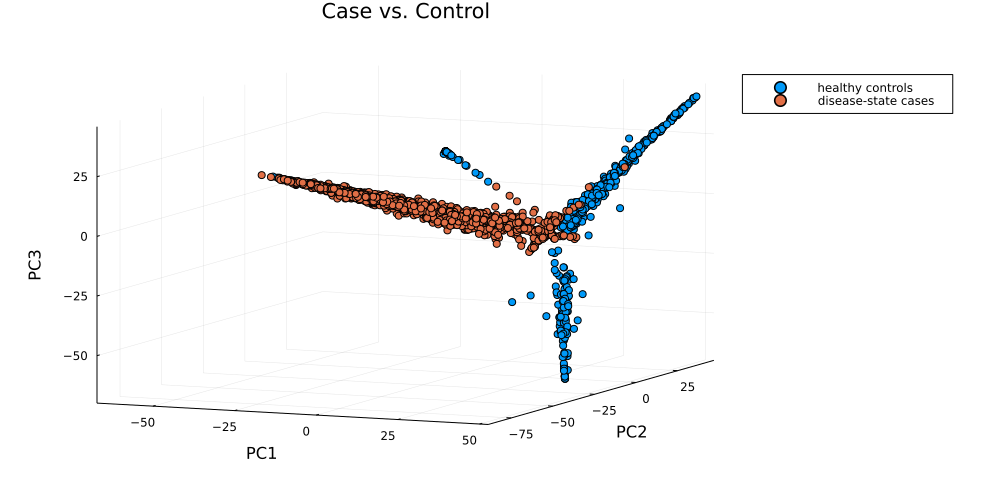

In [200]:
x = transformed_observations[1, :]
y = transformed_observations[2, :]
z = transformed_observations[3, :]

StatsPlots.plotlyjs()
StatsPlots.gr()

pc3_plot = 
StatsPlots.scatter(
    [x[control_indices], x[case_indices]],
    [y[control_indices], y[case_indices]],
    [z[control_indices], z[case_indices]],
    xlabel = "PC1",
    ylabel = "PC2",
    zlabel = "PC3",
    labels = ["healthy controls" "disease-state cases"],
    title = "Case vs. Control",
    legend = :outertopright,
    size = (1000, 500),
    margins = 1StatsPlots.cm,
)

display(pc3_plot)

Here we determine the centroids of the "average case" and the "average" control

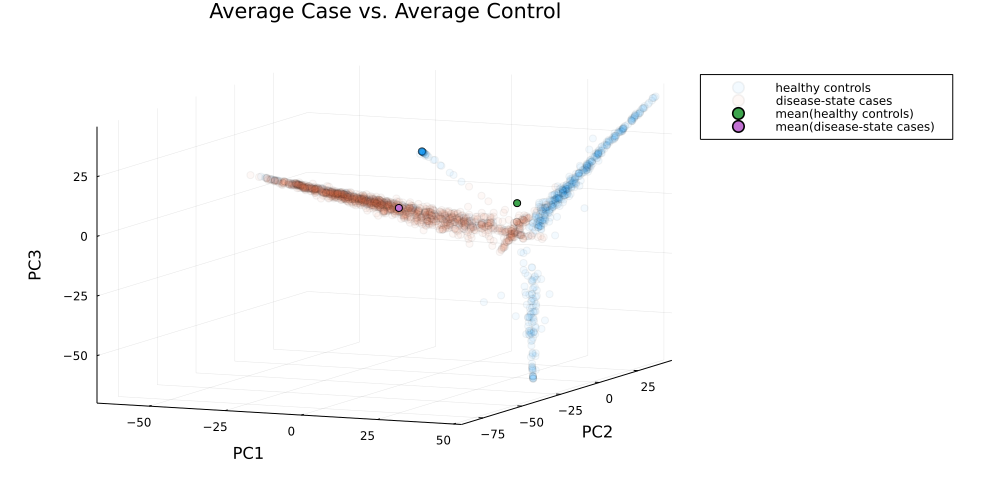

In [201]:
mean_of_transformed_controls = Statistics.mean(transformed_observations[:, control_indices], dims=2)
mean_of_transformed_cases = Statistics.mean(transformed_observations[:, case_indices], dims=2)

# transform midpiont back to original dimensions
reconstructed_mean_of_controls = MultivariateStats.reconstruct(pca_model, mean_of_transformed_controls)
reconstructed_mean_of_cases = MultivariateStats.reconstruct(pca_model, mean_of_transformed_cases)

xs = [
    x[control_indices],
    x[case_indices],
    mean_of_transformed_controls[1:1],
    mean_of_transformed_cases[1:1]
]

ys = [
    y[control_indices],
    y[case_indices],
    mean_of_transformed_controls[2:2],
    mean_of_transformed_cases[2:2]
]

zs = [
    z[control_indices],
    z[case_indices],
    mean_of_transformed_controls[3:3],
    mean_of_transformed_cases[3:3]
]

labels = [
    "healthy controls",
    "disease-state cases",
    "mean(healthy controls)",
    "mean(disease-state cases)"
]

StatsPlots.gr()

pc3_plot = 
StatsPlots.scatter(
    xs,
    ys,
    zs,
    xlabel = "PC1",
    ylabel = "PC2",
    zlabel = "PC3",
    legend = :outertopright,
    labels = hcat(labels...),
    size = (1000, 500),
    margins = 1StatsPlots.cm,
    alpha = [0.05 0.05 1.0 1.0],
    title = "Average Case vs. Average Control"
)

In [212]:
function determine_best_change(pca_model, reconstructed_mean_of_controls, current_distance, current_observation)
    best_change_index = 0
    for j in 1:length(current_observation)
        # skip evaluating equivalent values
        if current_observation[j] != reconstructed_mean_of_controls[j]
            candidate_observation = copy(current_observation)
            candidate_observation[j] = reconstructed_mean_of_controls[j]
            transformed_candidate_observation = MultivariateStats.transform(pca_model, candidate_observation)
            distance_to_mean_of_transformed_controls = Distances.euclidean(transformed_candidate_observation, mean_of_transformed_controls)
            if distance_to_mean_of_transformed_controls < current_distance
                current_distance = distance_to_mean_of_transformed_controls
                best_change_index = j
            end
        end
    end
    return best_change_index
end

determine_best_change (generic function with 1 method)

In [210]:
last_left_off = findfirst(x -> x == updates_table[end, "case_id"], ibd_sample_list)

315

In [ ]:
# family
# Progress: 100%|█████████████████████████████████████████| Time: 0:18:01

# updates_table = DataFrames.DataFrame(
#     case_id = String[],
#     feature_id = String[],
#     change = Float64[]
# )

ProgressMeter.@showprogress for case_index in case_indices[last_left_off+1:end]
    outlier_observation = observations[:, case_index]
    outlier_observation_updates = []
    for i in 1:length(outlier_observation)
        if i == 1
            modified_observation = copy(outlier_observation)
        else
            modified_observation = copy(last(outlier_observation_updates))
        end
        transformed_modified_observation = MultivariateStats.transform(pca_model, modified_observation)
        current_distance = Distances.euclidean(transformed_modified_observation, mean_of_transformed_controls)
        
        # update me to be more efficient?
        best_change_index = determine_best_change(pca_model, reconstructed_mean_of_controls, current_distance, modified_observation)
        modified_observation[best_change_index] = reconstructed_mean_of_controls[best_change_index]
        
        row = (
            case_id = joint_sample_id_list[case_index],
            feature_id = sorted_ranks[rank][best_change_index],
            change = reconstructed_mean_of_controls[best_change_index] - outlier_observation[best_change_index]
            )
        push!(updates_table, row)
        
        push!(outlier_observation_updates, modified_observation)
        
        
        
        transformed_modified_observation = MultivariateStats.transform(pca_model, modified_observation)
        distance_to_mean_controls = Distances.euclidean(transformed_modified_observation, mean_of_transformed_controls)
        distance_to_mean_cases = Distances.euclidean(transformed_modified_observation, mean_of_transformed_cases)
        if distance_to_mean_controls < distance_to_mean_cases
    #         @show "done!", i
            # we're now more similar to the controls than to the cases
            break
        end
    end
    # updated_observations

    updates_plot = 
    StatsPlots.scatter(
        pc3_plot,
        [x[case_index], [MultivariateStats.transform(pca_model, x)[1] for x in outlier_observation_updates]...],
        [y[case_index], [MultivariateStats.transform(pca_model, x)[2] for x in outlier_observation_updates]...],
        [z[case_index], [MultivariateStats.transform(pca_model, x)[3] for x in outlier_observation_updates]...],
        labels = "steps",
        color = collect(StatsPlots.cgrad(:matter, length(outlier_observation_updates) + 1, categorical = true)),
        title = "Modification path to reclassify case # $(case_index)\n$(length(outlier_observation_updates)) modifications"
    )
    
    updates_plot = 
    StatsPlots.plot(
        updates_plot,
        [x[case_index], [MultivariateStats.transform(pca_model, x)[1] for x in outlier_observation_updates]...],
        [y[case_index], [MultivariateStats.transform(pca_model, x)[2] for x in outlier_observation_updates]...],
        [z[case_index], [MultivariateStats.transform(pca_model, x)[3] for x in outlier_observation_updates]...],
        labels = "",
    )

#     mkpath("$(DIR)/$(rank)")
#     for extension in ["svg", "png"]
    for extension in ["svg"]
        d = "$(DIR)/$(rank)/update_plots/$(extension)"
        mkpath(d)
        StatsPlots.savefig(updates_plot, "$(d)/$(joint_sample_id_list[case_index]).$(rank).$(extension)")
    end
end
uCSV.write("$(DIR)/$(rank)/updates_table.tsv", updates_table, delim='\t')

Progress:  10%|███▉                                     |  ETA: 2:07:06

In [ ]:
p = StatsPlots.histogram(
    map(case_id -> count(updates_table[!, "case_id"] .== case_id), updates_table[!, "case_id"]),
    xlabel = "# of updates required",
    legend = false,
    ylabel = "# of samples",
    title = "$rank updates",
    size = (1000, 500),
    margin = 1StatsPlots.PlotMeasures.cm
)
StatsPlots.savefig(p, "$(rank)/updates_distribution.svg")
# StatsPlots.savefig(p, "$(rank)/updates_distribution.png")
display(p)

In [ ]:
unique(updates_table[!, "feature_id"])

sorted_features = sort(collect(StatsBase.countmap(updates_table[!, "feature_id"])), by=x->x[2], rev=true)

ys = [updates_table[updates_table[!, "feature_id"] .== feature, "change"] for feature in first.(sorted_features)]

xs = [[i + (rand(-1:2:1) * rand()/3) for j in 1:length(ys[i])] for i in 1:length(ys)]

change_plot = StatsPlots.scatter(
    xs, 
    ys,
    alpha = 0.5,
    ylabel = "% change",
    xticks = (1:length(first.(sorted_features)), first.(sorted_features)),
    xrotation=45,
    size = (1000, 500),
    margin = 1StatsPlots.PlotMeasures.cm,
    title = "$(rank)-level changes for reclassification from IBD to HHS",
    legend=false)
StatsPlots.hline!(change_plot, [0])
StatsPlots.savefig(change_plot, "$(DIR)/$(rank)/reclassification_changes.svg")
# StatsPlots.savefig(change_plot, "$(DIR)/$(rank)/reclassification_changes.png")
display(change_plot)